#3. BERT2BERT

This model is composed of a BERT encoder and a BERT decoder, initialised with pre-trained embeddings from BERT base uncased. The attention layer is initialised randomly. This model has 247,363,386 tunable parameters and overfits the data quickly, so we use a very small learning rate of 0.000001 and train it for only ten epochs.

In [ ]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [ ]:
#import statements
import sys
import os
import json
from tokenizers import BertWordPieceTokenizer
from tokenizers.processors import BertProcessing
from tokenizers import ByteLevelBPETokenizer
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizerFast , BertTokenizer
from transformers import BertModel, BertForMaskedLM, BertConfig, EncoderDecoderModel , BertLMHeadModel
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

##3a) Non-empathetic response as input

In [ ]:
#import csv into dataframe
data_df = pd.read_csv('drive/MyDrive/data.csv', encoding="latin1")

In [ ]:
train_df = data_df.iloc[: int(len(data_df) * 0.8 ) ,:  ]
val_df_copy = data_df.iloc[ len(data_df) - int(len(data_df) * 0.2 ) :  ,:  ]
val_df = val_df_copy.iloc[ int( len(val_df_copy) * 0.5 ) : , :  ]
test_df = val_df_copy.iloc[ : int( len(val_df_copy) * 0.5 ) , :  ]

train_df.to_csv( "train_data.csv" )
val_df.to_csv( "val_data.csv" )
test_df.to_csv( "test_data.csv" )

In [ ]:
for i_row in data_df.iterrows():
  print(i_row[1].source)
  break

Been in a similar situation after taking some time off of school. My best advice is to take the minimum amount of classes possible so you get too overwhelmed. For me essential to plan my assignments in advance, so that I can just do things one by one and not let it all get piled up cuz then I wanna die. Also, if you need a break, take one. School will always be there but good to take care of yourself too  


In [ ]:
def convert_text( en_file , en_comp_file , data_df  ):
  with open( en_file , "w") as my_output_file:
    [ my_output_file.write("".join(row[1].source)+'\n') for row in  data_df.iterrows() ]
    my_output_file.close()

  with open( en_comp_file , "w") as my_output_file:
    [ my_output_file.write("".join(row[1].target)+'\n') for row in  data_df.iterrows() ]
    my_output_file.close()


In [ ]:
train_en_file = 'train_en.txt' 
train_en_comp_file = "train_en_comp.txt"
convert_text( train_en_file , train_en_comp_file , train_df )

val_en_file = 'val_en.txt' 
val_en_comp_file = "val_en_comp.txt"
convert_text( val_en_file , val_en_comp_file , val_df )

test_en_file = 'test_en.txt' 
test_en_comp_file = "test_en_comp.txt"
convert_text( test_en_file , test_en_comp_file , test_df )

In [ ]:
globalparams ={
        "train_en_file" : "/content/train_en.txt",
        "train_en_comp_file" : "/content/train_en_comp.txt",
        "val_en_file":"/content/val_en.txt" , 
        "val_en_comp_file":"/content/val_en_comp.txt",
        "test_en_file":"/content/test_en.txt" , 
        "test_en_comp_file":"/content/test_en_comp.txt"}

encparams = {
        "tokenizer_path" : "tokenizers/",
        "file_name" : "en.text",
        "min_freq" : 0 ,
        "max_length" : 512,
        "num_attn_heads" : 8,
        "num_hidden_layers" : 8,
        "hidden_size" : 512 }

decparams = {
        "tokenizer_path" : "tokenizers/",
        "file_name" : "en_comp.text",
        "min_freq" : 0 ,
        "max_length" : 256,
        "num_attn_heads" : 8,
        "num_hidden_layers" : 8,
        "hidden_size" : 512}

modelparams = {
        "batch_size" : 4 ,
        "num_epochs" : 1,
        "lr": 0.000001,
        "model_path" : "models/",
        "model_name": "encdec.mdl"}

In [ ]:
tokenizer.cls_token = "[CLS]"
tokenizer.unk_token = "[UNK]"
tokenizer.sep_token = "[SEP]"
tokenizer.pad_token = "[PAD]" 
tokenizer.bos_token = "[S]"
tokenizer.mask_token = "[MASK]"
tokenizer.eos_token =  "[/S]"

In [ ]:
tokenizer.do_lower_case = True

tokenizer._tokenizer.post_processor = BertProcessing(("[SEP]", tokenizer.bos_token_id  ), 
                                                     ("[CLS]", tokenizer.cls_token_id   ),)

In [ ]:
len( tokenizer.get_vocab() )

30522

In [ ]:
class TranslationDataset(data.Dataset):

    def __init__(self, inp_file, targ_file, inp_tokenizer, targ_tokenizer, inp_maxlength, targ_maxlength):

        self.inp_tokenizer = inp_tokenizer
        self.targ_tokenizer = targ_tokenizer
        self.inp_maxlength = inp_maxlength
        self.targ_maxlength = targ_maxlength

        print("Loading and Tokenizing the data ...")
        self.encoded_inp = []
        self.encoded_targ = []

        # Read the source lines
        num_inp_lines = 0
        with open(inp_file, "r") as ef:
            for line in ef:
                enc = self.inp_tokenizer.encode(line.strip(), add_special_tokens=True, max_length=self.inp_maxlength , truncation=True)
                self.encoded_inp.append(torch.tensor(enc))
                num_inp_lines += 1

        # read the target lines
        num_targ_lines = 0
        with open(targ_file, "r") as df:
            for line in df:
                enc = self.targ_tokenizer.encode(line.strip(), add_special_tokens=True, max_length=self.targ_maxlength , truncation=True)
                self.encoded_targ.append(torch.tensor(enc))
                num_targ_lines += 1

        assert (num_inp_lines==num_targ_lines), "Mismatch in source and target lines"
        print("Read", num_inp_lines, "lines from source and target files.")

    def __getitem__(self, offset):
        src = self.encoded_inp[offset]
        trg = self.encoded_targ[offset]

        return src, src.shape[0], trg, trg.shape[0]

    def __len__(self):
        return len(self.encoded_inp)

    def collate_function(self, batch):

        (inputs, inp_lengths, targets, targ_lengths) = zip(*batch)

        padded_inputs = self._collate_helper(inputs, self.inp_tokenizer)
        padded_targets = self._collate_helper(targets, self.targ_tokenizer)

        max_inp_seq_len = padded_inputs.shape[1]
        max_out_seq_len = padded_targets.shape[1]

        input_masks = [[1]*l + [0]*(max_inp_seq_len-l) for l in inp_lengths]
        target_masks = [[1]*l + [0]*(max_out_seq_len-l) for l in targ_lengths]

        input_tensor = padded_inputs.to(torch.int64)
        target_tensor = padded_targets.to(torch.int64)
        input_masks = torch.Tensor(input_masks)
        target_masks = torch.Tensor(target_masks)

        return input_tensor, input_masks, target_tensor, target_masks

    def _collate_helper(self, examples, tokenizer):
        length_of_first = examples[0].size(0)
        are_tensors_same_length = all(x.size(0) == length_of_first for x in examples)
        if are_tensors_same_length:
            return torch.stack(examples, dim=0)
        else:
            if tokenizer._pad_token is None:
                raise ValueError(
                    "You are attempting to pad samples but the tokenizer you are using"
                    f" ({tokenizer.__class__.__name__}) does not have one."
                )
            return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

In [ ]:
# Load the tokenizers
en_tokenizer = tokenizer
en_complex_tokenizer = tokenizer

# Init the dataset
train_en_file = globalparams["train_en_file"]
train_en_complex_file = globalparams["train_en_comp_file"]
val_en_file = globalparams["val_en_file"]
val_en_complex_file = globalparams["val_en_comp_file"]
test_en_file = globalparams["test_en_file"]
test_en_complex_file = globalparams["test_en_comp_file"]

enc_maxlength = encparams["max_length"]
dec_maxlength = decparams["max_length"]

batch_size = modelparams["batch_size"]

train_dataset = TranslationDataset( train_en_file, train_en_complex_file, en_tokenizer, en_complex_tokenizer, enc_maxlength, dec_maxlength)
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, \
                                                drop_last=True, num_workers=1, collate_fn=train_dataset.collate_function)

Loading and Tokenizing the data ...
Read 986 lines from source and target files.


In [ ]:
valid_dataset = TranslationDataset(val_en_file, val_en_complex_file, en_tokenizer, en_complex_tokenizer, enc_maxlength, dec_maxlength)
valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, \
                                                drop_last=True, num_workers=1, collate_fn=valid_dataset.collate_function)

Loading and Tokenizing the data ...
Read 123 lines from source and target files.


In [ ]:
test_dataset = TranslationDataset(test_en_file, test_en_complex_file, en_tokenizer, en_complex_tokenizer, enc_maxlength, dec_maxlength)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, \
                                                drop_last=True, num_workers=1, collate_fn=test_dataset.collate_function)

Loading and Tokenizing the data ...
Read 123 lines from source and target files.


In [ ]:
x , _ , y , _ = next(iter(train_dataloader))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [ ]:
bert2bert = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relatio

In [ ]:
bert2bert.config.decoder_start_token_id = tokenizer.cls_token_id
bert2bert.config.eos_token_id = tokenizer.sep_token_id
bert2bert.config.pad_token_id = tokenizer.pad_token_id
bert2bert.config.vocab_size = bert2bert.config.encoder.vocab_size

In [ ]:
bert2bert.config.max_length = 120
bert2bert.config.min_length = 56
bert2bert.config.no_repeat_ngram_size = 2
bert2bert.config.early_stopping = True
bert2bert.config.length_penalty = 2.0
bert2bert.config.num_beams = 5

In [ ]:
bert2bert.to(device)

EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [ ]:
#define optimiser and loss function
optimizer = optim.Adam( bert2bert.parameters(), lr=modelparams['lr'])
criterion = nn.CrossEntropyLoss(ignore_index= tokenizer.pad_token_id)

num_train_batches = len(train_dataloader)
num_valid_batches = len(valid_dataloader)
num_test_batches = len(test_dataloader)

In [ ]:
def compute_loss(predictions, targets):
    """Compute our custom loss"""
    predictions = predictions[:, :-1, :].contiguous()
    targets = targets[:, 1:]

    rearranged_output = predictions.view(predictions.shape[0]*predictions.shape[1], -1)
    rearranged_target = targets.contiguous().view(-1)

    loss = criterion(rearranged_output, rearranged_target)


    return loss

In [ ]:
tr = {'loss': [], 'PPL': []}

def train_model():
    bert2bert.train()
    epoch_loss = 0
    

    for i, (en_input, en_masks, de_output, de_masks) in enumerate(train_dataloader):

        optimizer.zero_grad()

        en_input = en_input.to(device)
        de_output = de_output.to(device)
        en_masks = en_masks.to(device)
        de_masks = de_masks.to(device)

        lm_labels = de_output.clone()
        out = bert2bert(input_ids=en_input, attention_mask=en_masks,
                                        decoder_input_ids=de_output, decoder_attention_mask=de_masks, labels=lm_labels)
        prediction_scores = out[1]
        predictions = F.log_softmax(prediction_scores, dim=2)
        loss = compute_loss(predictions, de_output)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert2bert.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item()

    train_loss = epoch_loss / num_train_batches

    # store logs
    tr['loss'].append(train_loss)
    tr['PPL'].append(math.exp(train_loss))

    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')

In [ ]:
val = {'loss': [], 'PPL': []}

def eval_model():
    bert2bert.eval()
    epoch_loss = 0
    

    for i, (en_input, en_masks, de_output, de_masks) in enumerate(valid_dataloader):

        optimizer.zero_grad()

        en_input = en_input.to(device)
        de_output = de_output.to(device)
        en_masks = en_masks.to(device)
        de_masks = de_masks.to(device)

        lm_labels = de_output.clone()

        out = bert2bert(input_ids=en_input, attention_mask=en_masks,
                                        decoder_input_ids=de_output, decoder_attention_mask=de_masks, labels=lm_labels)

        prediction_scores = out[1]
        predictions = F.log_softmax(prediction_scores, dim=2)
        loss = compute_loss(predictions, de_output)
        epoch_loss += loss.item()

    valid_loss =  epoch_loss / num_valid_batches 

    # store logs
    val['loss'].append(valid_loss)
    val['PPL'].append(math.exp(valid_loss))

    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
tst = {'loss': [], 'PPL': []}

def test_model():
    bert2bert.eval()
    epoch_loss = 0
    

    for i, (en_input, en_masks, de_output, de_masks) in enumerate(test_dataloader):

        optimizer.zero_grad()

        en_input = en_input.to(device)
        de_output = de_output.to(device)
        en_masks = en_masks.to(device)
        de_masks = de_masks.to(device)

        lm_labels = de_output.clone()

        out = bert2bert(input_ids=en_input, attention_mask=en_masks,
                                        decoder_input_ids=de_output, decoder_attention_mask=de_masks, labels=lm_labels)

        prediction_scores = out[1]
        predictions = F.log_softmax(prediction_scores, dim=2)
        loss = compute_loss(predictions, de_output)
        epoch_loss += loss.item()

    test_loss =  epoch_loss / num_valid_batches 

    # store logs
    tst['loss'].append(test_loss)
    tst['PPL'].append(math.exp(test_loss))

    print(f'\t Test Loss: {test_loss:.3f} |  Test PPL: {math.exp(test_loss):7.3f}')
    return test_loss

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(bert2bert):,} trainable parameters')

The model has 247,363,386 trainable parameters


In [ ]:
# MAIN TRAINING LOOP
for epoch in range(10):
    print("Starting epoch", epoch+1)
    train_model()
    eval_model()

Starting epoch 1
	Train Loss: 6.585 | Train PPL: 724.265
	 Val. Loss: 5.968 |  Val. PPL: 390.677
Starting epoch 2
	Train Loss: 5.835 | Train PPL: 342.229
	 Val. Loss: 5.541 |  Val. PPL: 255.034
Starting epoch 3
	Train Loss: 5.516 | Train PPL: 248.607
	 Val. Loss: 5.240 |  Val. PPL: 188.727
Starting epoch 4
	Train Loss: 5.276 | Train PPL: 195.557
	 Val. Loss: 5.043 |  Val. PPL: 154.887
Starting epoch 5
	Train Loss: 5.108 | Train PPL: 165.285
	 Val. Loss: 4.911 |  Val. PPL: 135.800
Starting epoch 6
	Train Loss: 4.983 | Train PPL: 145.870
	 Val. Loss: 4.815 |  Val. PPL: 123.339
Starting epoch 7
	Train Loss: 4.886 | Train PPL: 132.373
	 Val. Loss: 4.739 |  Val. PPL: 114.312
Starting epoch 8
	Train Loss: 4.800 | Train PPL: 121.549
	 Val. Loss: 4.678 |  Val. PPL: 107.516
Starting epoch 9
	Train Loss: 4.726 | Train PPL: 112.799
	 Val. Loss: 4.628 |  Val. PPL: 102.352
Starting epoch 10
	Train Loss: 4.654 | Train PPL: 105.007
	 Val. Loss: 4.584 |  Val. PPL:  97.878


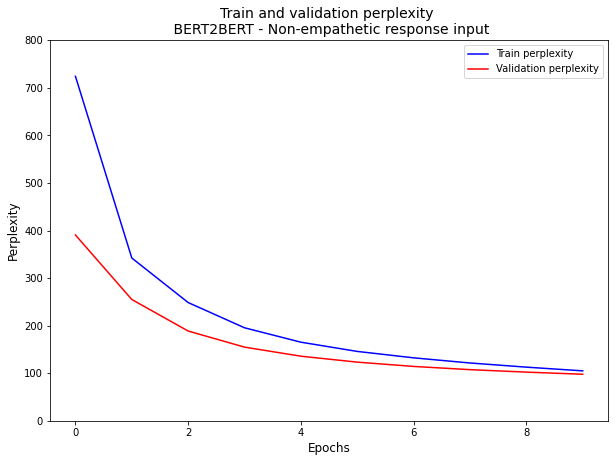

In [ ]:
#plot train and validation PPL logs

fig = plt.figure(figsize=(10,7))

y1 = tr['PPL']
y2 = val['PPL']

plt.plot(y1, "-b", label="Train perplexity")
plt.plot(y2, "-r", label="Validation perplexity")
plt.legend(loc="upper right")
plt.ylim(0, 800)
plt.ylabel('Perplexity', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.title("Train and validation perplexity \n BERT2BERT - Non-empathetic response input", fontsize = 14)

fig.savefig("3a-ppl.pdf")
plt.show()

In [ ]:
test_loss_3a = test_model()

	 Test Loss: 4.478 |  Test PPL:  88.056


In [ ]:
print("Saving model ..")
save_location = modelparams['model_path']
model_name = modelparams['model_name']
if not os.path.exists(save_location):
    os.makedirs(save_location)
save_location = os.path.join(save_location, model_name)
torch.save(bert2bert, save_location)

In [ ]:
def generate_sentence(model, iterator):
    
    model.eval()
    
    epoch_loss = 0

    pred_trg_pairs = []

    with torch.no_grad():
    
        for i, (en_input, en_masks, de_output, de_masks) in enumerate(iterator):

            en_input = en_input.to(device)
            de_output = de_output.to(device)
            en_masks = en_masks.to(device)
            de_masks = de_masks.to(device)

            lm_labels = de_output.clone()

            out = model(input_ids=en_input, attention_mask=en_masks,
                                            decoder_input_ids=de_output, decoder_attention_mask=de_masks, labels=lm_labels)
            prediction_scores = out[1]
            outputs = torch.argmax( prediction_scores , dim = -1 )
            output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            target_str = tokenizer.batch_decode( de_output , skip_special_tokens=True)

            for i_pred , i_trg in zip( output_str , target_str  ):

              print( "Target Sentence : {} \n".format( i_trg )  )
              print( "Predicted Sentence : {} \n".format( i_pred )  )
            
            break

In [ ]:
generate_sentence( bert2bert , test_dataloader )

Target Sentence : i think that avoiding work to sit at home in your misery is a bad thing. getting out of the house is recommended even if it's something like going to work. obviously do whatever you feel is best but i don't think skipping work is going to help you get any better. for example i could barely get out of bed this morning to go to work but even though i'm here hating it i would alternatively be at home sleeping until 2pm then lay in bed on my phone all day. 

Predicted Sentence : i'i i you. try. at. my head. a bad thing. i better of the world. a to if i is s not to that on get. i i have i want like going to i'' t know it.. going to try me. out job job i you if'try get to of the. way. try out sleep. i if i'm trying to myself,'really try able the. out i.. i out the. the bed...'' just a doing've just a least home sleep sleep the... i the bed bed. i i i my the the the the the a. if is.. just'just trying least the sleep sleep sleep out the the the.. a bad hard. i a my the my i 

##3b) Seeker post + non-empathetic response as input

In [ ]:
#import csv into dataframe
data_df = pd.read_csv('drive/MyDrive/data.csv', encoding="latin1")

In [ ]:
#split into train, val and test sets (80-10-10)
train_df = data_df.iloc[: int(len(data_df) * 0.8 ) ,:  ]
val_df_copy = data_df.iloc[ len(data_df) - int(len(data_df) * 0.2 ) :  ,:  ]
val_df = val_df_copy.iloc[ int( len(val_df_copy) * 0.5 ) : , :  ]
test_df = val_df_copy.iloc[ : int( len(val_df_copy) * 0.5 ) , :  ]

train_df.to_csv( "train_data.csv" )
val_df.to_csv( "val_data.csv" )
test_df.to_csv( "test_data.csv" )

In [ ]:
def convert_text( en_file , en_comp_file , data_df  ):
  with open( en_file , "w") as my_output_file:
    [ my_output_file.write("".join( row[1].seeker_post + " SPLIT " +  row[1].source )+'\n') for row in  data_df.iterrows() ]
    my_output_file.close()

  with open( en_comp_file , "w") as my_output_file:
    [ my_output_file.write("".join( row[1].target)+'\n') for row in  data_df.iterrows() ]
    my_output_file.close()


In [ ]:
train_en_file = 'train_en.txt' 
train_en_comp_file = "train_en_comp.txt"
convert_text( train_en_file , train_en_comp_file , train_df )


val_en_file = 'val_en.txt' 
val_en_comp_file = "val_en_comp.txt"
convert_text( val_en_file , val_en_comp_file , val_df )

test_en_file = 'test_en.txt' 
test_en_comp_file = "test_en_comp.txt"
convert_text( test_en_file , test_en_comp_file , test_df )

In [ ]:
globalparams ={
        "train_en_file" : "/content/train_en.txt",
        "train_en_comp_file" : "/content/train_en_comp.txt",
        "val_en_file":"/content/val_en.txt" , 
        "val_en_comp_file":"/content/val_en_comp.txt",
        "test_en_file":"/content/test_en.txt" , 
        "test_en_comp_file":"/content/test_en_comp.txt" }

encparams = {
        "tokenizer_path" : "tokenizers/",
        "file_name" : "en.text",
        "min_freq" : 0 ,
        "max_length" : 512,
        "num_attn_heads" : 8,
        "num_hidden_layers" : 8,
        "hidden_size" : 512 }

decparams = {
        "tokenizer_path" : "tokenizers/",
        "file_name" : "en_comp.text",
        "min_freq" : 0 ,
        "max_length" : 120 ,
        "num_attn_heads" : 8,
        "num_hidden_layers" : 8,
        "hidden_size" : 512}

modelparams = {
        "batch_size" : 4 ,
        "num_epochs" : 1,
        "lr": 0.000001,
        "model_path" : "models/",
        "model_name": "encdec.mdl"}

In [ ]:
tokenizer.model_max_length

512

In [ ]:
tokenizer.cls_token = "[CLS]"
tokenizer.unk_token = "[UNK]"
tokenizer.sep_token = "[SEP]"
tokenizer.pad_token = "[PAD]" 
tokenizer.bos_token = "[S]"
tokenizer.mask_token = "[MASK]"
tokenizer.eos_token =  "[/S]"

In [ ]:
tokenizer.do_lower_case = True

tokenizer._tokenizer.post_processor = BertProcessing(("[SEP]", tokenizer.bos_token_id  ), 
                                                     ("[CLS]", tokenizer.cls_token_id   ),)

In [ ]:
class TranslationDataset(data.Dataset):

    def __init__(self, inp_file, targ_file, inp_tokenizer, targ_tokenizer, inp_maxlength, targ_maxlength):

        self.inp_tokenizer = inp_tokenizer
        self.targ_tokenizer = targ_tokenizer
        self.inp_maxlength = inp_maxlength
        self.targ_maxlength = targ_maxlength

        print("Loading and Tokenizing the data ...")
        self.encoded_inp = []
        self.encoded_targ = []

        # Read the source lines
        num_inp_lines = 0
        with open(inp_file, "r") as ef:
            for line in ef:
                enc = self.inp_tokenizer.encode(line.strip(), add_special_tokens=True, max_length=self.inp_maxlength , truncation=True)
                self.encoded_inp.append(torch.tensor(enc))
                num_inp_lines += 1

        # read the target lines
        num_targ_lines = 0
        with open(targ_file, "r") as df:
            for line in df:
                enc = self.targ_tokenizer.encode(line.strip(), add_special_tokens=True, max_length=self.targ_maxlength , truncation=True)
                self.encoded_targ.append(torch.tensor(enc))
                num_targ_lines += 1

        assert (num_inp_lines==num_targ_lines), "Mismatch in source and target lines"
        print("Read", num_inp_lines, "lines from source and target files.")

    def __getitem__(self, offset):
        src = self.encoded_inp[offset]
        trg = self.encoded_targ[offset]

        return src, src.shape[0], trg, trg.shape[0]

    def __len__(self):
        return len(self.encoded_inp)

    def collate_function(self, batch):

        (inputs, inp_lengths, targets, targ_lengths) = zip(*batch)

        padded_inputs = self._collate_helper(inputs, self.inp_tokenizer)
        padded_targets = self._collate_helper(targets, self.targ_tokenizer)

        max_inp_seq_len = padded_inputs.shape[1]
        max_out_seq_len = padded_targets.shape[1]

        input_masks = [[1]*l + [0]*(max_inp_seq_len-l) for l in inp_lengths]
        target_masks = [[1]*l + [0]*(max_out_seq_len-l) for l in targ_lengths]

        input_tensor = padded_inputs.to(torch.int64)
        target_tensor = padded_targets.to(torch.int64)
        input_masks = torch.Tensor(input_masks)
        target_masks = torch.Tensor(target_masks)

        return input_tensor, input_masks, target_tensor, target_masks

    def _collate_helper(self, examples, tokenizer):
        length_of_first = examples[0].size(0)
        are_tensors_same_length = all(x.size(0) == length_of_first for x in examples)
        if are_tensors_same_length:
            return torch.stack(examples, dim=0)
        else:
            if tokenizer._pad_token is None:
                raise ValueError(
                    "You are attempting to pad samples but the tokenizer you are using"
                    f" ({tokenizer.__class__.__name__}) does not have one."
                )
            return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

In [ ]:
# Load the tokenizers
en_tokenizer = tokenizer
en_complex_tokenizer = tokenizer

# Init the dataset
train_en_file = globalparams["train_en_file"]
train_en_complex_file = globalparams["train_en_comp_file"]
val_en_file = globalparams["val_en_file"]
val_en_complex_file = globalparams["val_en_comp_file"]
test_en_file = globalparams["test_en_file"]
test_en_complex_file = globalparams["test_en_comp_file"]

enc_maxlength = encparams["max_length"]
dec_maxlength = decparams["max_length"]

batch_size = modelparams["batch_size"]

train_dataset = TranslationDataset( train_en_file, train_en_complex_file, en_tokenizer, en_complex_tokenizer, enc_maxlength, dec_maxlength)
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, \
                                                drop_last=True, num_workers=1, collate_fn=train_dataset.collate_function)

Loading and Tokenizing the data ...
Read 986 lines from source and target files.


In [ ]:
valid_dataset = TranslationDataset(val_en_file, val_en_complex_file, en_tokenizer, en_complex_tokenizer, enc_maxlength, dec_maxlength)
valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, \
                                                drop_last=True, num_workers=1, collate_fn=valid_dataset.collate_function)

Loading and Tokenizing the data ...
Read 123 lines from source and target files.


In [ ]:
test_dataset = TranslationDataset(test_en_file, test_en_complex_file, en_tokenizer, en_complex_tokenizer, enc_maxlength, dec_maxlength)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, \
                                                drop_last=True, num_workers=1, collate_fn=test_dataset.collate_function)

Loading and Tokenizing the data ...
Read 123 lines from source and target files.


In [ ]:
x , _ , y , _ = next(iter(train_dataloader))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [ ]:
bert2bert = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relatio

In [ ]:
bert2bert.config.decoder_start_token_id = tokenizer.cls_token_id
bert2bert.config.eos_token_id = tokenizer.sep_token_id
bert2bert.config.pad_token_id = tokenizer.pad_token_id
bert2bert.config.vocab_size = bert2bert.config.encoder.vocab_size

In [ ]:
bert2bert.config.max_length = 120
bert2bert.config.min_length = 56
bert2bert.config.no_repeat_ngram_size = 3
bert2bert.config.early_stopping = True
bert2bert.config.length_penalty = 2.0
bert2bert.config.num_beams = 5

In [ ]:
bert2bert.to(device)

EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [ ]:
#define optimiser and loss function
optimizer = optim.Adam( bert2bert.parameters(), lr=modelparams['lr'])
criterion = nn.CrossEntropyLoss(ignore_index= tokenizer.pad_token_id)

num_train_batches = len(train_dataloader)
num_valid_batches = len(valid_dataloader)
num_test_batches = len(test_dataloader)

In [ ]:
def compute_loss(predictions, targets):
    """Compute our custom loss"""
    predictions = predictions[:, :-1, :].contiguous()
    targets = targets[:, 1:]

    rearranged_output = predictions.view(predictions.shape[0]*predictions.shape[1], -1)
    rearranged_target = targets.contiguous().view(-1)

    loss = criterion(rearranged_output, rearranged_target)


    return loss

In [ ]:
tr = {'loss': [], 'PPL': []}

def train_model():
    bert2bert.train()
    epoch_loss = 0
    

    for i, (en_input, en_masks, de_output, de_masks) in enumerate(train_dataloader):

        optimizer.zero_grad()

        en_input = en_input.to(device)
        de_output = de_output.to(device)
        en_masks = en_masks.to(device)
        de_masks = de_masks.to(device)

        lm_labels = de_output.clone()
        out = bert2bert(input_ids=en_input, attention_mask=en_masks,
                                        decoder_input_ids=de_output, decoder_attention_mask=de_masks, labels=lm_labels)
        prediction_scores = out[1]
        predictions = F.log_softmax(prediction_scores, dim=2)
        loss = compute_loss(predictions, de_output)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert2bert.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item()

    train_loss = epoch_loss / num_train_batches

    # store logs
    tr['loss'].append(train_loss)
    tr['PPL'].append(math.exp(train_loss))

    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')

In [ ]:
val = {'loss': [], 'PPL': []}

def eval_model():
    bert2bert.eval()
    epoch_loss = 0
    

    for i, (en_input, en_masks, de_output, de_masks) in enumerate(valid_dataloader):

        optimizer.zero_grad()

        en_input = en_input.to(device)
        de_output = de_output.to(device)
        en_masks = en_masks.to(device)
        de_masks = de_masks.to(device)

        lm_labels = de_output.clone()

        out = bert2bert(input_ids=en_input, attention_mask=en_masks,
                                        decoder_input_ids=de_output, decoder_attention_mask=de_masks, labels=lm_labels)

        prediction_scores = out[1]
        predictions = F.log_softmax(prediction_scores, dim=2)
        loss = compute_loss(predictions, de_output)
        epoch_loss += loss.item()

    valid_loss =  epoch_loss / num_valid_batches 

    # store logs
    val['loss'].append(valid_loss)
    val['PPL'].append(math.exp(valid_loss))

    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
tst = {'loss': [], 'PPL': []}

def test_model():
    bert2bert.eval()
    epoch_loss = 0
    

    for i, (en_input, en_masks, de_output, de_masks) in enumerate(test_dataloader):

        optimizer.zero_grad()

        en_input = en_input.to(device)
        de_output = de_output.to(device)
        en_masks = en_masks.to(device)
        de_masks = de_masks.to(device)

        lm_labels = de_output.clone()

        out = bert2bert(input_ids=en_input, attention_mask=en_masks,
                                        decoder_input_ids=de_output, decoder_attention_mask=de_masks, labels=lm_labels)

        prediction_scores = out[1]
        predictions = F.log_softmax(prediction_scores, dim=2)
        loss = compute_loss(predictions, de_output)
        epoch_loss += loss.item()

    test_loss =  epoch_loss / num_valid_batches 

    # store logs
    tst['loss'].append(test_loss)
    tst['PPL'].append(math.exp(test_loss))

    print(f'\t Test Loss: {test_loss:.3f} |  Test PPL: {math.exp(test_loss):7.3f}')
    return test_loss

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(bert2bert):,} trainable parameters')

The model has 247,363,386 trainable parameters


In [ ]:
# MAIN TRAINING LOOP
for epoch in range(10):
    print("Starting epoch", epoch+1)
    train_model()
    eval_model()

Starting epoch 1
	Train Loss: 6.573 | Train PPL: 715.370
	 Val. Loss: 5.982 |  Val. PPL: 396.061
Starting epoch 2
	Train Loss: 5.846 | Train PPL: 345.835
	 Val. Loss: 5.541 |  Val. PPL: 254.855
Starting epoch 3
	Train Loss: 5.529 | Train PPL: 251.966
	 Val. Loss: 5.240 |  Val. PPL: 188.685
Starting epoch 4
	Train Loss: 5.306 | Train PPL: 201.522
	 Val. Loss: 5.053 |  Val. PPL: 156.433
Starting epoch 5
	Train Loss: 5.142 | Train PPL: 171.044
	 Val. Loss: 4.924 |  Val. PPL: 137.599
Starting epoch 6
	Train Loss: 5.017 | Train PPL: 150.925
	 Val. Loss: 4.831 |  Val. PPL: 125.394
Starting epoch 7
	Train Loss: 4.920 | Train PPL: 137.070
	 Val. Loss: 4.758 |  Val. PPL: 116.470
Starting epoch 8
	Train Loss: 4.833 | Train PPL: 125.550
	 Val. Loss: 4.699 |  Val. PPL: 109.870
Starting epoch 9
	Train Loss: 4.764 | Train PPL: 117.246
	 Val. Loss: 4.644 |  Val. PPL: 103.908
Starting epoch 10
	Train Loss: 4.690 | Train PPL: 108.886
	 Val. Loss: 4.604 |  Val. PPL:  99.872


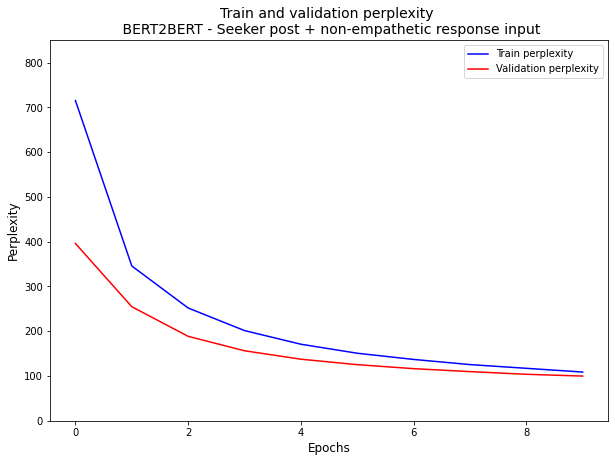

In [ ]:
#plot train and validation PPL logs

fig = plt.figure(figsize=(10,7))

y1 = tr['PPL']
y2 = val['PPL']

plt.plot(y1, "-b", label="Train perplexity")
plt.plot(y2, "-r", label="Validation perplexity")
plt.legend(loc="upper right")
plt.ylim(0, 850)
plt.ylabel('Perplexity', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.title("Train and validation perplexity \n BERT2BERT - Seeker post + non-empathetic response input", fontsize = 14)

fig.savefig("3b-ppl.pdf")
plt.show()

In [ ]:
test_loss_3b = test_model()

	 Test Loss: 4.512 |  Test PPL:  91.141


In [ ]:
print("Saving model ..")
save_location = modelparams['model_path']
model_name = modelparams['model_name']
if not os.path.exists(save_location):
    os.makedirs(save_location)
save_location = os.path.join(save_location, model_name)
torch.save(bert2bert, save_location)

Saving model ..


In [ ]:
def generate_sentence(model, iterator):
    
    model.eval()
    
    epoch_loss = 0

    pred_trg_pairs = []

    with torch.no_grad():
    
        for i, (en_input, en_masks, de_output, de_masks) in enumerate(iterator):

            en_input = en_input.to(device)
            de_output = de_output.to(device)
            en_masks = en_masks.to(device)
            de_masks = de_masks.to(device)

            lm_labels = de_output.clone()

            out = model(input_ids=en_input, attention_mask=en_masks,
                                            decoder_input_ids=de_output, decoder_attention_mask=de_masks, labels=lm_labels)
            prediction_scores = out[1]
            outputs = torch.argmax( prediction_scores , dim = -1 )
            output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            target_str = tokenizer.batch_decode( de_output , skip_special_tokens=True)

            for i_pred , i_trg in zip( output_str , target_str  ):

              print( "Target Sentence : {} \n".format( i_trg )  )
              print( "Predicted Sentence : {} \n".format( i_pred )  )
            
            break

In [ ]:
generate_sentence( bert2bert , test_dataloader )

Target Sentence : i think that avoiding work to sit at home in your misery is a bad thing. getting out of the house is recommended even if it's something like going to work. obviously do whatever you feel is best but i don't think skipping work is going to help you get any better. for example i could barely get out of bed this morning to go to work but even though i'm here hating it i would alternatively be at home sleeping until 2pm then lay in bed on my phone all day. 

Predicted Sentence : i'i i you. try in a. the head. a bad thing. i better of the world. a to to i is s a.. to sleep. i i i i want like going to i'' t have it to. going to work me. out more things i me,'' have to of the. way. try out sleep out i i i'm not to myself'' never be able the. out up.. i out the bed bed bed. of. i'' just it feeling the a a a my least sleep a 

Target Sentence : it is unfair. modern psychology / psychiatry is completely incapable of helping those who are in severe pain with lifelong battles wit

#4. PLOT PERPLEXITY FOR ALL MODELS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

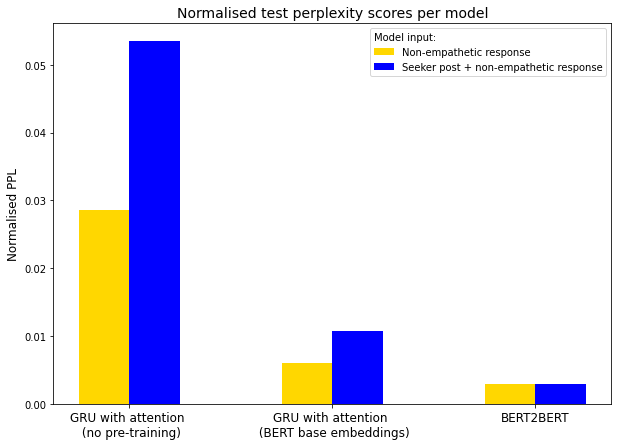

In [ ]:
labels = ['GRU with attention \n (no pre-training)', 'GRU with attention \n (BERT base embeddings)', 'BERT2BERT']
non_empathetic_response = [math.exp(test_loss_1a)/8410, math.exp(test_loss_2a)/30522, math.exp(test_loss_3a)/30522] 
non_empathetic_response_seeker_post = [math.exp(test_loss_1b)/8410, math.exp(test_loss_2b)/30522, math.exp(test_loss_3b)/30522]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars
fig, ax = plt.subplots(figsize=(10,7))
#rects1 = ax.bar(x - width/3, non_empathetic_response, width, label='Non-empathetic response')
#rects3 = ax.bar(x + width/3, non_empathetic_response_seeker_post, width, label='Seeker post + non-empathetic response')

ax.bar(x - width/2, non_empathetic_response, width, label='Non-empathetic response', color='gold')
ax.bar(x + width/2, non_empathetic_response_seeker_post, width, label='Seeker post + non-empathetic response',  color='b')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Normalised PPL', fontsize= 12)
#ax.set_yscale('log')
ax.set_title('Normalised test perplexity scores per model', fontsize= 14)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize= 12)

leg = plt.legend(title="Model input:")
leg._legend_box.align = "left"

fig.savefig('testppl.pdf')
plt.show()